In [36]:
import numpy as np
import torch
import torch.nn as nn
from keras.datasets import mnist
from matplotlib import pyplot as plt
import math
from tqdm import tqdm
import torchvision
import torchvision.datasets

In [37]:
EPOCHS = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODELS = []
BATCH_SIZE = 100

In [38]:
# (train_X, _), (test_X, _) = mnist.load_data()
# train_X = torch.from_numpy(train_X).float()
# test_X = torch.from_numpy(test_X).float()
# type(train_X)
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

In [39]:
# trainset=trainset*2-1

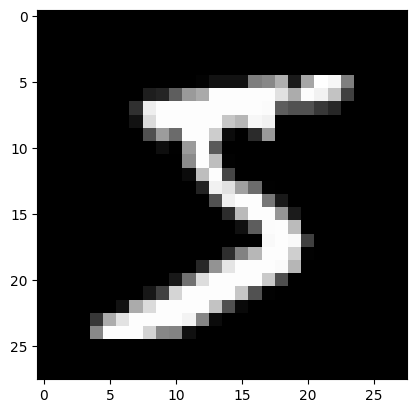

In [40]:
plt.subplot()
plt.imshow(trainset[0][0].squeeze(0), cmap=plt.get_cmap('gray'))
plt.show()

In [41]:
#DataLoader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset = trainset,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset = testset,
                              batch_size = BATCH_SIZE,
                              shuffle = False)

In [42]:
class LatentfromX(nn.Module):
    def __init__(self, input_channels, latent_dims):
        super().__init__()
        self.stack = nn.Sequential(
            # nn.Conv2d(in_channels=input_channels, out_channels=3, kernel_size=4),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2),
            # nn.Conv2d(in_channels=3, out_channels=3, kernel_size=2),
            # nn.ReLU(),
            nn.Linear(in_features = input_channels, out_features = 256),
            nn.Tanh(),
            nn.Linear(in_features = 256, out_features = 64),
            nn.Tanh()
        )
        self.mean_layer = nn.Sequential(
            # nn.Flatten(),
            # nn.Linear(in_features=11 * 11 * 3, out_features=latent_dims),
            nn.Linear(in_features = 64, out_features = latent_dims),
            nn.Tanh()
        )
        self.log_var_layer = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(in_features=64, out_features=latent_dims),
            nn.Tanh()
        )

    def forward(self, z):
        z = self.stack(z)
        return self.mean_layer(z), self.log_var_layer(z)

In [43]:
class ReconstructFromLatent(nn.Module):
    def __init__(self, latent_dims, output_dims):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Linear(in_features=latent_dims, out_features=196),
            nn.Tanh(),
            nn.Linear(in_features=196, out_features=256),
            nn.Tanh(),
            nn.Linear(in_features=256, out_features=576),
            nn.Tanh(),
        )
        self.reconstruct = nn.Sequential(
            nn.Linear(in_features=576, out_features=output_dims),
            nn.Sigmoid(),
        )
        # self.mean_layer = nn.Sequential(
        #     nn.Linear(in_features=576, out_features=output_dims),
        #     nn.Tanh(),
        # )
        # self.log_std_layer = nn.Sequential(
        #     nn.Linear(in_features=576, out_features=output_dims),
        #     nn.Tanh(),
        # )

    def forward(self, x):
        x = self.stack(x)
        return self.reconstruct(x)

In [44]:
class VAE(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        #q(z|x)
        self.qz_x = LatentfromX(input_channels=28*28, latent_dims=latent_dims)
        #p(x|z)
        self.px_z = ReconstructFromLatent(latent_dims=latent_dims, output_dims=28*28)

    def forward(self, x):
        z_mean, z_log_var = self.qz_x(x)
        # reparameterized = z_mean + (torch.exp(z_log_var * 0.5) * np.random.normal(0, 1))
        reparameterized = z_mean + (torch.exp(z_log_var * 0.5) * torch.randn_like(z_log_var).to(DEVICE))
        reconstructed_x = self.px_z(reparameterized)
        return z_mean, z_log_var, reconstructed_x

In [45]:
reconstruction_error_history = []
kl_div_error_history= []
total_error_history = []
for i in range(6):
  reconstruction_error_history.append([])
  kl_div_error_history.append([])
  total_error_history.append([])
  latent_dims = 2**(i+1)
  VAEModel = VAE(latent_dims=latent_dims).to(DEVICE)
  optimizer = torch.optim.Adam(params=VAEModel.parameters(), lr=1e-3)
  loss_fn = nn.MSELoss(reduction="sum")
  VAEModel.train()
  for epoch in (range(EPOCHS)):
      loss=0
      total_reconstruction_error = 0
      total_kl_div_error = 0
      total_error = 0
      for batch, (x,y) in tqdm(enumerate(train_dataloader)):
          # x=2*x-1
          # print(x.shape)
          x=x.view(BATCH_SIZE, 28*28).to(DEVICE)
          z_mean, z_log_var, reconstructed_x = VAEModel(x.to(DEVICE))
          # print(x.flatten(start_dim=1).shape, reconstructed_x.shape)
          reconstruction_error = loss_fn(reconstructed_x.to(DEVICE), x.flatten(start_dim=1).to(DEVICE))
          # print(reconstruction_error.shape)
          # kl_div_error = torch.mean(0.5*torch.sum(torch.exp(z_log_var) + z_mean**2 -1 - z_log_var, dim=-1))
          kl_div_error = torch.sum(0.5*torch.sum(torch.exp(z_log_var) + z_mean**2 -1 - z_log_var, dim=-1))
          # print(kl_div_error.shape, reconstruction_error.shape)
          # loss=reconstruction_error+0.00001*kl_div_error
          loss=reconstruction_error+kl_div_error

          total_reconstruction_error += reconstruction_error
        #   print(reconstruction_error, kl_div_error)
          total_kl_div_error += torch.mean(kl_div_error).item()

          optimizer.zero_grad()
          # print(loss.shape)
          loss.backward()
          optimizer.step()

    #   total_reconstruction_error/=len(trainset)
    #   total_kl_div_error/=len(trainset)
      total_error = total_reconstruction_error + total_kl_div_error

      reconstruction_error_history[i].append(total_reconstruction_error)
      kl_div_error_history[i].append(total_kl_div_error)
      total_error_history[i].append(total_error)

      print(f"\nlatent_dim: {latent_dims} | epoch: {epoch+1} | re_loss: {total_reconstruction_error:.2f} | kl_div: {total_kl_div_error:.2f} | loss: {total_error:.2f}")
  MODELS.append(VAEModel)


600it [00:22, 26.21it/s]



latent_dim: 2 | epoch: 1 | re_loss: 3090101.75 | kl_div: 44005.17 | loss: 3134107.00


600it [00:21, 27.99it/s]



latent_dim: 2 | epoch: 2 | re_loss: 2813689.50 | kl_div: 65252.89 | loss: 2878942.50


600it [00:20, 28.98it/s]



latent_dim: 2 | epoch: 3 | re_loss: 2802014.50 | kl_div: 65122.88 | loss: 2867137.50


600it [00:20, 29.84it/s]



latent_dim: 2 | epoch: 4 | re_loss: 2796078.75 | kl_div: 64994.09 | loss: 2861072.75


600it [00:21, 28.50it/s]



latent_dim: 2 | epoch: 5 | re_loss: 2791347.25 | kl_div: 65066.18 | loss: 2856413.50


600it [00:19, 30.80it/s]



latent_dim: 4 | epoch: 1 | re_loss: 2943639.50 | kl_div: 80558.21 | loss: 3024197.75


600it [00:20, 29.73it/s]



latent_dim: 4 | epoch: 2 | re_loss: 2511834.00 | kl_div: 133991.28 | loss: 2645825.25


600it [00:19, 30.56it/s]



latent_dim: 4 | epoch: 3 | re_loss: 2470840.75 | kl_div: 138475.63 | loss: 2609316.50


600it [00:19, 30.18it/s]



latent_dim: 4 | epoch: 4 | re_loss: 2466814.75 | kl_div: 139686.44 | loss: 2606501.25


600it [00:20, 29.69it/s]



latent_dim: 4 | epoch: 5 | re_loss: 2453554.75 | kl_div: 139801.06 | loss: 2593355.75


600it [00:19, 30.86it/s]



latent_dim: 8 | epoch: 1 | re_loss: 2972010.50 | kl_div: 96617.31 | loss: 3068627.75


600it [00:21, 28.22it/s]



latent_dim: 8 | epoch: 2 | re_loss: 2291587.25 | kl_div: 230521.29 | loss: 2522108.50


600it [00:33, 18.04it/s]



latent_dim: 8 | epoch: 3 | re_loss: 2136051.50 | kl_div: 259864.55 | loss: 2395916.00


600it [00:23, 25.45it/s]



latent_dim: 8 | epoch: 4 | re_loss: 2080659.75 | kl_div: 268251.49 | loss: 2348911.25


600it [00:20, 29.76it/s]



latent_dim: 8 | epoch: 5 | re_loss: 2049970.00 | kl_div: 272556.43 | loss: 2322526.50


600it [00:19, 30.60it/s]



latent_dim: 16 | epoch: 1 | re_loss: 2976841.00 | kl_div: 110233.37 | loss: 3087074.25


600it [00:20, 29.76it/s]



latent_dim: 16 | epoch: 2 | re_loss: 2183324.75 | kl_div: 309612.37 | loss: 2492937.00


600it [00:21, 28.29it/s]



latent_dim: 16 | epoch: 3 | re_loss: 1958635.12 | kl_div: 372733.07 | loss: 2331368.25


600it [00:19, 30.96it/s]



latent_dim: 16 | epoch: 4 | re_loss: 1852539.38 | kl_div: 406238.92 | loss: 2258778.25


600it [00:22, 27.00it/s]



latent_dim: 16 | epoch: 5 | re_loss: 1778912.88 | kl_div: 434839.96 | loss: 2213752.75


600it [00:20, 29.50it/s]



latent_dim: 32 | epoch: 1 | re_loss: 2857579.25 | kl_div: 155181.82 | loss: 3012761.00


600it [00:19, 30.94it/s]



latent_dim: 32 | epoch: 2 | re_loss: 2102094.25 | kl_div: 358412.79 | loss: 2460507.00


600it [00:20, 29.56it/s]



latent_dim: 32 | epoch: 3 | re_loss: 1929794.00 | kl_div: 405309.40 | loss: 2335103.50


600it [00:19, 30.75it/s]



latent_dim: 32 | epoch: 4 | re_loss: 1817801.12 | kl_div: 442658.37 | loss: 2260459.50


600it [00:20, 29.58it/s]



latent_dim: 32 | epoch: 5 | re_loss: 1755269.38 | kl_div: 462019.98 | loss: 2217289.25


600it [00:20, 29.49it/s]



latent_dim: 64 | epoch: 1 | re_loss: 2960081.50 | kl_div: 145461.01 | loss: 3105542.50


600it [00:19, 30.63it/s]



latent_dim: 64 | epoch: 2 | re_loss: 2194529.00 | kl_div: 347976.72 | loss: 2542505.75


600it [00:20, 29.63it/s]



latent_dim: 64 | epoch: 3 | re_loss: 1985457.12 | kl_div: 403101.68 | loss: 2388558.75


600it [00:19, 30.70it/s]



latent_dim: 64 | epoch: 4 | re_loss: 1865732.12 | kl_div: 440581.82 | loss: 2306314.00


600it [00:20, 29.37it/s]


latent_dim: 64 | epoch: 5 | re_loss: 1790845.12 | kl_div: 462371.80 | loss: 2253217.00


In [46]:
# for k,model in enumerate(MODELS):
#   model.eval()
#   # torch.manual_seed(42)
#   fig = plt.figure(figsize = (9, 9))
#   fig.suptitle(f"Latent dimension = {2**(k+1)}")
#   rows, cols = 5, 2
#   imgs = []
#   for i in range(5):
#     imgs.append(testset[i])
#   # for i in range(1, rows*cols+1):
#   #   for img, label in imgs:

#   #     # img, label = trainset[j]
#   #     fig.add_subplot(rows, cols, i)
#   #     plt.imshow(img.squeeze(), cmap = "gray")
#   #     plt.title(class_names[label])
#   #     plt.axis(False)
#   index = 0
#   test_features_batch, test_labels_batch = next(iter(test_dataloader))
#   for row in range(rows):
#     fig.add_subplot(rows, cols, row*2 + 1)
#     plt.imshow(test_features_batch[index].squeeze(), cmap="gray")
#     plt.title("Original")
#     plt.axis(False)
#     with torch.inference_mode():
#       fig.add_subplot(rows, cols, row*2 + 2)
#       _,_,re_x = model(test_features_batch.flatten(start_dim=1).to(DEVICE))
#       # re_x = torch.log(re_x+1)*255
#       # re_x = (re_x+1)/2
#       re_x=re_x[index].reshape(28,28)
#       plt.imshow(re_x.detach().to("cpu").numpy(), cmap="gray")
#       plt.title("Reconstructed")
#       plt.axis(False)

#     index+=1

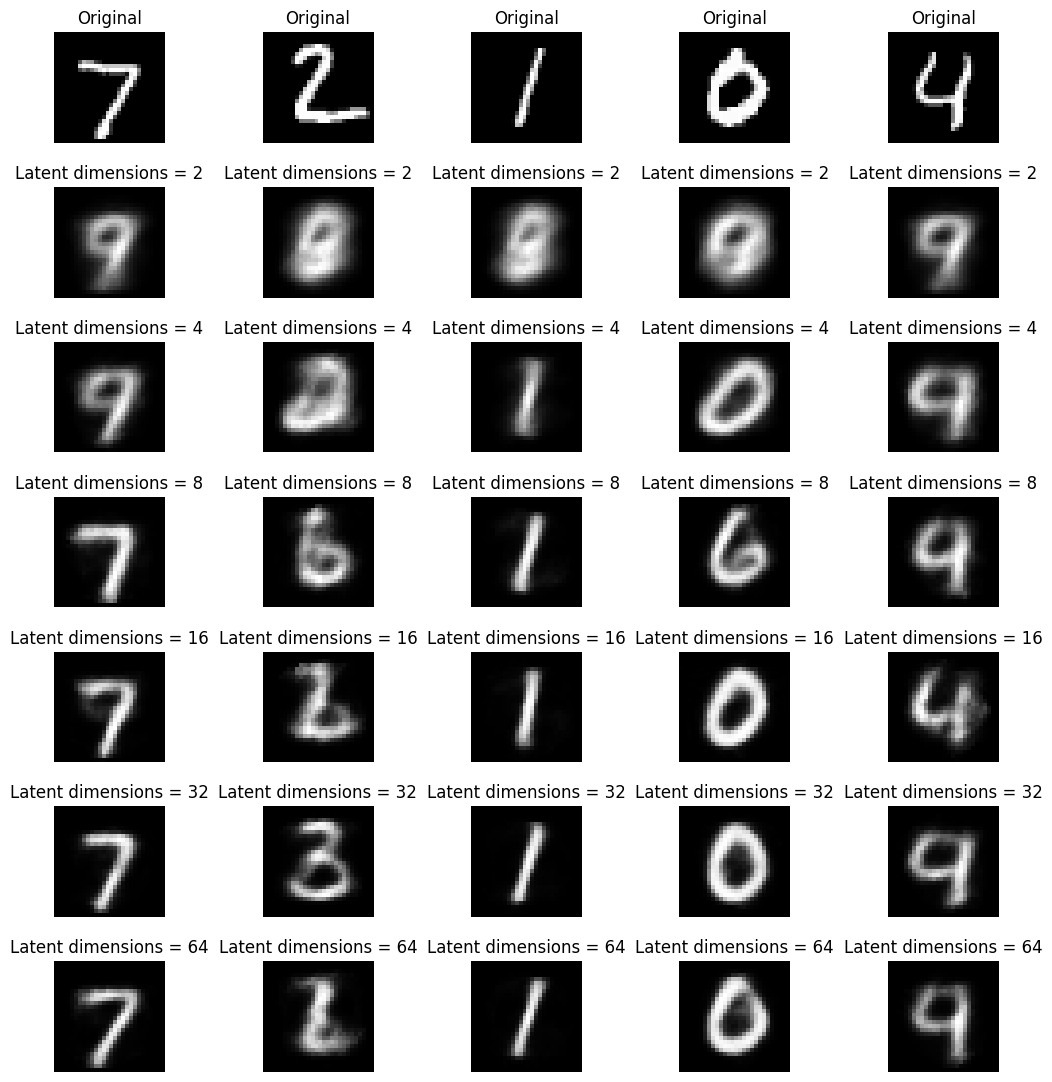

In [47]:
fig = plt.figure(figsize = (13, 13))
rows, cols = 7, 5

test_features_batch, test_labels_batch = next(iter(test_dataloader))
for j in range(5):
  fig.add_subplot(rows, cols, j+1)
  plt.imshow(test_features_batch[j].squeeze(), cmap="gray")
  plt.title("Original")
  plt.axis(False)
  plt.subplots_adjust(hspace=0.4)

for k,model in enumerate(MODELS):
  model.eval()

  with torch.inference_mode():
    _,_,re_x = model(test_features_batch.flatten(start_dim=1).to(DEVICE))

  for j in range(5):
    re_x_shaped=re_x[j].reshape(28,28)

    fig.add_subplot(rows, cols, (k+1)*5+(j+1))
    plt.imshow(re_x_shaped.detach().to("cpu").numpy(), cmap="gray")
    plt.title(f"Latent dimensions = {2**(k+1)}")
    plt.axis(False)
    plt.subplots_adjust(bottom=0.1, top=0.9)

In [48]:
def mse(y_true, y_pred):
    return np.sum((y_true - y_pred)**2)

In [50]:
mse_vals=[]
test_dataloader = DataLoader(dataset = testset,
                              batch_size = BATCH_SIZE,
                              shuffle = False)

for model in MODELS:
  model.eval()
  mse_val=0
  with torch.inference_mode():
    for x_test, y in test_dataloader:
      _,_,re_x_test = model(x_test.flatten(start_dim=1).to(DEVICE))

      x_test_flat = x_test.flatten().to("cpu").numpy()
      re_x_test_flat = re_x_test.flatten().detach().to("cpu").numpy()

      mse_val += mse(x_test_flat, re_x_test_flat)


  mse_val /= len(testset)
  mse_vals.append(mse_val)

print(f"MSE values are = {mse_vals}")

MSE values are = [46.50078955078125, 40.92877468261719, 33.81099011230469, 28.9330943359375, 28.973575048828124, 29.06528957519531]
